# **VIRTUAL RACE ENGINEER**

In [1]:
import fastf1 as ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1.plotting
fastf1.plotting.setup_mpl()
import fastf1.api as fap
fastf1.Cache.enable_cache(r"D:\Prabhu\SEM 7\F1 Data")
import re
import datetime as dt
import fastf1.mvapi as famp
import fastf1.events as fae
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder

d:\Prabhu\SEM 7\F1 Data\.venv\Lib\site-packages\fastf1\api.py:32: UserWarning: `fastf1.api` will be considered private in future releases and potentially be removed or changed!
  warnings.warn("`fastf1.api` will be considered private in future releases and "


### LOADING SESSION

In [2]:
session = ff.get_session(2023,'Dutch','R')
session.load()
session_start_time=session.t0_date

core           INFO 	Loading data for Dutch Grand Prix - Race [v3.3.7]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2023/13/results.json failed; using cached response
Traceback (most recent call last):
  File "d:\Prabhu\SEM 7\F1 Data\.venv\Lib\site-packages\requests_cache\session.py", line 290, in _resend
    response.raise_for_status()
  File "d:\Prabhu\SEM 7\F1 Data\.venv\Lib\site-packages\requests\models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Backend fetch failed for url: https://ergast.com/api/f1/2023/13/results.json
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using

In [3]:
laps=session.laps
drivers=laps['Driver'].unique()

### FETCHING TELEMETRY DATA 

In [4]:
total_telemetry=[]
for i in drivers:
    drivers_laps=laps.pick_driver(i)
    driver_telemetry=drivers_laps.get_car_data()
    
    driver_telemetry['Driver']=i
    total_telemetry.append(driver_telemetry)
telemetry_data=pd.concat(total_telemetry,ignore_index=True)

### FETCHING WEATHER,TYRE,LAP AND POSITION DATA 

In [5]:
weather_data=pd.DataFrame(fap.weather_data(session.api_path))
tyre_data = laps[['Driver', 'LapNumber', 'Compound', 'FreshTyre','TyreLife']]
lap_data=laps[['Time','Driver','DriverNumber','LapNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','IsAccurate']]
position_data=laps[['Driver','DriverNumber','LapNumber','Position','LapStartTime']]

req            INFO 	Using cached data for weather_data


### FETCHING RACE CONTROL MESSAGES

In [6]:
rcm_data = pd.DataFrame(fap.race_control_messages(session.api_path))
master_msg=rcm_data[['Time','Category','Flag','Status','Message']]

req            INFO 	Using cached data for race_control_messages


In [7]:
# #Filter for Yellow, Red, VSC, SC 
# yellow_flags_key=['YELLOW','DOUBLE YELLOW']
# red_flags_key=['RED']
# vsc_key=['VSC','VIRTUAL SAFETY CAR']
# sc_key=['SC','SAFETY CAR']

# #Searching using the keyword in REGEX
# yellow_flags = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in yellow_flags_key))]
# red_flags = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in red_flags_key))]
# vsc = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in vsc_key))]
# sc = msg[msg['Message'].apply(lambda x: any(re.search(r'\b{}\b'.format(keyword), x) for keyword in sc_key))]
# master_msg=pd.concat([yellow_flags,red_flags,vsc,sc], axis=0)

# pd.set_option('display.max_columns', None)

### FETCHING LAP DATA (PITS STOPS, DRIVER POSITION ETC.)

In [8]:
lapsdata, streamdata = fap.timing_data(session.api_path)
lapsdata=pd.DataFrame(lapsdata)
lapsdata['DriverNumber'] = lapsdata['Driver']
gapdata=pd.DataFrame(streamdata)
gapdata['DriverNumber'] = gapdata['Driver']
gap_data = gapdata[['Time','DriverNumber','Position','GapToLeader','IntervalToPositionAhead']]
laps_data=lapsdata[['Time','DriverNumber','LapTime','NumberOfPitStops','PitOutTime','PitInTime']]

req            INFO 	Using cached data for _extended_timing_data


### GETTING CORNERS INFO

In [9]:
circuit_info=session.get_circuit_info()
corners_data=circuit_info.corners

### MAKING A MASTER DATA (POSITION DATA, POSITION DATA, LAPS DATA)
###### NOTE:WE ARE KEEPING THE GAP DATA, WEATHER DATA, RACE CONTROL MESSAGES AND THE TELEMETRY DATA SEPERATE BECAUSE EACH DATA IS GENERATED IN A COMPLETELY DIFFERENT TIME

In [10]:
master_data = lap_data.merge(position_data, on=['Driver', 'DriverNumber', 'LapNumber'], how='left')
master_data = master_data.merge(tyre_data, on=['Driver', 'LapNumber'], how='left')
master_data = master_data.merge(laps_data, on=['DriverNumber','Time','LapTime'], how='left')

#### FILLING THE MISSING LAPTIME VALUES WITH BACKWARD FILL

In [11]:
columns_to_fill=['LapTime','Sector1Time','Sector2Time','Sector3Time']
master_data[columns_to_fill]=master_data[columns_to_fill].fillna(method='bfill')

C:\Users\prabh\AppData\Local\Temp\ipykernel_6424\3161052701.py:2: FutureWarning: Laps.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_data[columns_to_fill]=master_data[columns_to_fill].fillna(method='bfill')


### CONVERTING TIME TO SECONDS

In [12]:
master_data['Sector1Time(s)']=master_data['Sector1Time'].dt.total_seconds()
master_data['Sector2Time(s)']=master_data['Sector2Time'].dt.total_seconds()
master_data['Sector3Time(s)']=master_data['Sector3Time'].dt.total_seconds()
master_data['Cum.SectorTime(s)']=master_data['Sector1Time(s)']+master_data['Sector2Time(s)']+master_data['Sector3Time(s)']
master_data['LapTime(s)']=master_data['LapTime'].dt.total_seconds()
master_data['LapStartTime(s)']=master_data['LapStartTime'].dt.total_seconds()
master_data['PitInTime(s)']=master_data['PitInTime'].dt.total_seconds()
master_data['PitOutTime(s)']=master_data['PitOutTime'].dt.total_seconds().shift(-1)

#### CALCULATING PITSTOP TIME AND LAP DELTA

In [13]:
master_data['PitStopTime(s)']=master_data['PitOutTime(s)']-master_data['PitInTime(s)']
master_data['PrevLapTime(s)']=master_data['LapTime(s)'].shift(1)
master_data['LapΔ(s)']=master_data['LapTime(s)']-master_data['PrevLapTime(s)']

In [14]:
master_data=master_data.sort_values(by=['LapNumber','Position'])
master_data['CumLapTime(s)'] = master_data.groupby('Driver')['LapTime(s)'].cumsum()

#### DEFINING FUNCTION TO CALCULATE GAP TO LEADER AND INTERVAL AT THE END OF EACH LAP

In [15]:
def gap_and_interval(df):
    gap_to_leader=[]
    interval=[]
    for i in df['LapNumber'].unique():
        lap=df[df['LapNumber']==i]
        leader_time=lap.iloc[0]['CumLapTime(s)']
        lap.loc[:,'GapToLeader']=lap['CumLapTime(s)']-leader_time
        lap.loc[:,'Interval']=lap['CumLapTime(s)'].diff().fillna(0)
        gap_to_leader.extend(lap['GapToLeader'].tolist())
        interval.extend(lap['Interval'].tolist())
    return gap_to_leader,interval
master_data['GapToLeader'],master_data['Interval']=gap_and_interval(master_data)
master_data.loc[master_data['Position']==1,'GapToLeader']=0
master_data.loc[master_data['Position']==1,'Interval']=0

C:\Users\prabh\AppData\Local\Temp\ipykernel_6424\4238679693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap.loc[:,'GapToLeader']=lap['CumLapTime(s)']-leader_time
C:\Users\prabh\AppData\Local\Temp\ipykernel_6424\4238679693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap.loc[:,'Interval']=lap['CumLapTime(s)'].diff().fillna(0)
C:\Users\prabh\AppData\Local\Temp\ipykernel_6424\4238679693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

#### SCALING AND NORMALIZING THE DATA

In [16]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
toscale=['LapTime(s)', 'Sector1Time(s)', 'Sector2Time(s)', 'Sector3Time(s)', 
                    'CumLapTime(s)', 'GapToLeader', 'Interval', 'LapStartTime(s)', 
                    'PitInTime(s)', 'PitOutTime(s)', 'PitStopTime(s)', 'PrevLapTime(s)', 'LapΔ(s)','FreshTyre','NumberOfPitStops','TyreLife']
master_data[toscale] = scaler.fit_transform(master_data[toscale])
telemetry_columns_to_scale = ['Speed', 'Throttle', 'Brake', 'nGear', 'RPM', 'DRS']
telemetry_data[telemetry_columns_to_scale] = scaler.fit_transform(telemetry_data[telemetry_columns_to_scale])
weather_columns_to_scale = ['AirTemp', 'TrackTemp', 'Humidity', 'Pressure', 'WindSpeed', 'WindDirection','Rainfall']
weather_data[weather_columns_to_scale] = scaler.fit_transform(weather_data[weather_columns_to_scale])

#### FINDING MISSING DATA

In [17]:
master_missing=master_data.isnull().sum()
telemetry_missing=telemetry_data.isnull().sum()
weather_missing=weather_data.isnull().sum()

#### FILLING MISSING PITSTOP DATA 

In [18]:
colums_to_fill_zero=['NumberOfPitStops','PitInTime','PitOutTime','PitInTime(s)','PitOutTime(s)','PitStopTime(s)','PrevLapTime(s)','LapΔ(s)']
master_data[colums_to_fill_zero]=master_data[colums_to_fill_zero].fillna(0)

In [19]:
master_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,...,LapTime(s),LapStartTime(s),PitInTime(s),PitOutTime(s),PitStopTime(s),PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,...,1.121812,-1.021743,0.0,0.0,0.0,0.000000,0.000000,-1.032224,-0.782261,-0.539581
839,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,...,1.174297,-1.021743,0.0,0.0,0.0,0.436815,7.646212,-1.032004,-0.765248,-0.368175
216,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,...,1.218362,-1.021743,0.0,0.0,0.0,0.313716,9.377063,-1.031818,-0.750964,-0.395675
1127,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,...,1.257194,-1.021743,0.0,0.0,0.0,0.391614,8.972493,-1.031655,-0.738376,-0.412762
560,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,...,1.341808,-1.021743,0.0,0.0,0.0,0.492235,8.806602,-1.031300,-0.710949,-0.263249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,...,0.492152,1.880784,0.0,0.0,0.0,0.428315,0.672027,1.081052,1.606763,-0.646109
982,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 00:00:28.745000,0 days 00:00:26.055000,True,14.0,...,0.468362,1.881296,0.0,0.0,0.0,0.511770,-0.438426,1.085957,1.985345,3.274596
487,0 days 03:26:36.084000,MAG,20,72.0,0 days 00:01:23.550000,0 days 00:00:29.009000,0 days 00:00:28.794000,0 days 00:00:25.747000,True,15.0,...,0.464928,1.881397,0.0,0.0,0.0,0.494605,-0.296234,1.104666,3.429450,14.009612
1270,0 days 03:26:37.061000,BOT,77,72.0,0 days 00:01:23.030000,0 days 00:00:28.882000,0 days 00:00:28.443000,0 days 00:00:25.705000,True,16.0,...,0.422417,1.881903,0.0,0.0,0.0,0.409678,0.143039,1.084104,1.842324,-16.529702


#### ENCODING CATEGORICAL REPRESENTATION

In [20]:
from sklearn.preprocessing import OneHotEncoder
master_data=pd.get_dummies(master_data,columns=['Compound'])

In [21]:
master_msg=pd.get_dummies(master_msg,columns=['Category','Flag'])
master_msg['Time'] = master_msg['Time'] - session_start_time

In [22]:
master_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,...,PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,...,0.000000,0.000000,-1.032224,-0.782261,-0.539581,False,False,False,True,False
839,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,...,0.436815,7.646212,-1.032004,-0.765248,-0.368175,False,False,False,True,False
216,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,...,0.313716,9.377063,-1.031818,-0.750964,-0.395675,False,False,False,True,False
1127,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,...,0.391614,8.972493,-1.031655,-0.738376,-0.412762,False,False,False,True,False
560,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,...,0.492235,8.806602,-1.031300,-0.710949,-0.263249,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,...,0.428315,0.672027,1.081052,1.606763,-0.646109,False,True,False,False,False
982,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 00:00:28.745000,0 days 00:00:26.055000,True,14.0,...,0.511770,-0.438426,1.085957,1.985345,3.274596,False,True,False,False,False
487,0 days 03:26:36.084000,MAG,20,72.0,0 days 00:01:23.550000,0 days 00:00:29.009000,0 days 00:00:28.794000,0 days 00:00:25.747000,True,15.0,...,0.494605,-0.296234,1.104666,3.429450,14.009612,False,True,False,False,False
1270,0 days 03:26:37.061000,BOT,77,72.0,0 days 00:01:23.030000,0 days 00:00:28.882000,0 days 00:00:28.443000,0 days 00:00:25.705000,True,16.0,...,0.409678,0.143039,1.084104,1.842324,-16.529702,False,True,False,False,False


In [23]:
telemetry_data

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Driver
0,2023-08-27 13:03:05.416,0.108055,-0.612440,-0.5,-0.07,0.0,0.0,car,0 days 00:00:00.082000,0 days 01:02:05.042000,VER
1,2023-08-27 13:03:05.616,0.105258,-0.612440,-0.5,-0.07,0.0,0.0,car,0 days 00:00:00.282000,0 days 01:02:05.242000,VER
2,2023-08-27 13:03:05.897,-0.038877,-0.607656,-0.5,-0.07,0.0,0.0,car,0 days 00:00:00.563000,0 days 01:02:05.523000,VER
3,2023-08-27 13:03:06.097,-0.169401,-0.559809,-0.5,-0.07,0.0,0.0,car,0 days 00:00:00.763000,0 days 01:02:05.723000,VER
4,2023-08-27 13:03:06.497,-0.430449,-0.497608,-0.5,-0.06,0.0,0.0,car,0 days 00:00:01.163000,0 days 01:02:06.123000,VER
...,...,...,...,...,...,...,...,...,...,...,...
601328,2023-08-27 15:27:25.367,0.255081,0.794258,1.0,0.77,0.0,0.0,car,0 days 02:24:20.033000,0 days 03:26:24.993000,PIA
601329,2023-08-27 15:27:25.527,0.257785,0.799043,1.0,0.77,0.0,0.0,car,0 days 02:24:20.193000,0 days 03:26:25.153000,PIA
601330,2023-08-27 15:27:25.687,0.261794,0.799043,1.0,0.77,0.0,0.0,car,0 days 02:24:20.353000,0 days 03:26:25.313000,PIA
601331,2023-08-27 15:27:26.047,0.263285,0.803828,1.0,0.77,0.0,0.0,car,0 days 02:24:20.713000,0 days 03:26:25.673000,PIA


In [24]:
weather_data

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:46.338000,0.176471,0.000000,-0.428571,0.0,-0.015152,0.766667,-0.285714
1,0 days 00:01:46.337000,0.176471,-0.090909,-0.285714,0.0,-0.015152,0.666667,0.428571
2,0 days 00:02:46.336000,0.176471,-0.181818,-0.428571,0.0,-0.015152,0.133333,0.714286
3,0 days 00:03:46.335000,0.235294,-0.090909,-0.428571,0.0,0.000000,0.366667,-0.714286
4,0 days 00:04:46.349000,0.235294,-0.090909,-0.285714,0.0,0.000000,0.433333,0.000000
...,...,...,...,...,...,...,...,...
204,0 days 03:24:47.183000,-0.823529,1.000000,0.714286,1.0,-1.000000,0.100000,0.142857
205,0 days 03:25:47.182000,-0.764706,0.818182,0.714286,1.0,-0.984848,-0.400000,0.142857
206,0 days 03:26:47.181000,-0.764706,0.818182,0.714286,1.0,-0.984848,-0.333333,-0.285714
207,0 days 03:27:47.180000,-0.823529,0.545455,1.000000,0.0,-1.015152,0.633333,0.428571


#### MERGING ALL DATA WITH MASTER DATA

In [25]:
master_data_sorted=master_data.sort_values('Time')
master_msg_sorted=master_msg.sort_values('Time')
merged_data = pd.merge_asof(master_data_sorted, weather_data, left_on='Time', right_on='Time', direction='nearest')
merged_data=pd.merge_asof(merged_data, master_msg_sorted, left_on='Time', right_on='Time', direction='nearest')
pd.set_option('display.max_columns', None)
# merged_data.to_excel('merged_data.xlsx', index=False)

#### FILLING THE NULL VALUES IN STATUS WITH TRACK CLEAR

In [26]:
merged_data_missing=merged_data.isnull().sum()
merged_data[['Status']]=merged_data[['Status']].fillna("TRACK CLEAR")
merged_data_missing=merged_data.isnull().sum()

#### DRIVERS AND THEIR TEAMS

In [28]:
driver_team_map = {
    'VER': 'RedBull',
    'PER': 'RedBull',
    'HAM': 'Mercedes',
    'RUS': 'Mercedes',
    'LEC': 'Ferrari',
    'SAI': 'Ferrari',
    'NOR': 'Mclaren',
    'PIA': 'Mclaren',
    'ALO': 'Aston Martin',
    'STR': 'Aston Martin',
    'OCO': 'Alpine',
    'GAS': 'Alpine',
    'TSU': 'VCARB',
    'RIC': 'VCARB',
    'LAW': 'VCARB',
    'MAG': 'Haas',
    'HUL': 'Haas',
    'BOT': 'Sauber',
    'ZHO': 'Sauber',
    'SAR': 'Williams',
    'ALB': 'Williams'

}

#### GETTING THE TEAM COLOR OF THE DRIVER

In [29]:
def get_team_color(driver):
    team = driver_team_map.get(driver, 'Unknown')
    if team == 'Unknown':
        return 'black'
    return ff.plotting.team_color(team)

#### DRIVERS TO PLOT

In [30]:
drivers_to_plot = ['HAM', 'ALO']

#### LAP TIME PLOTTING BETWEEN DRIVERS USING MATPLOTLIB

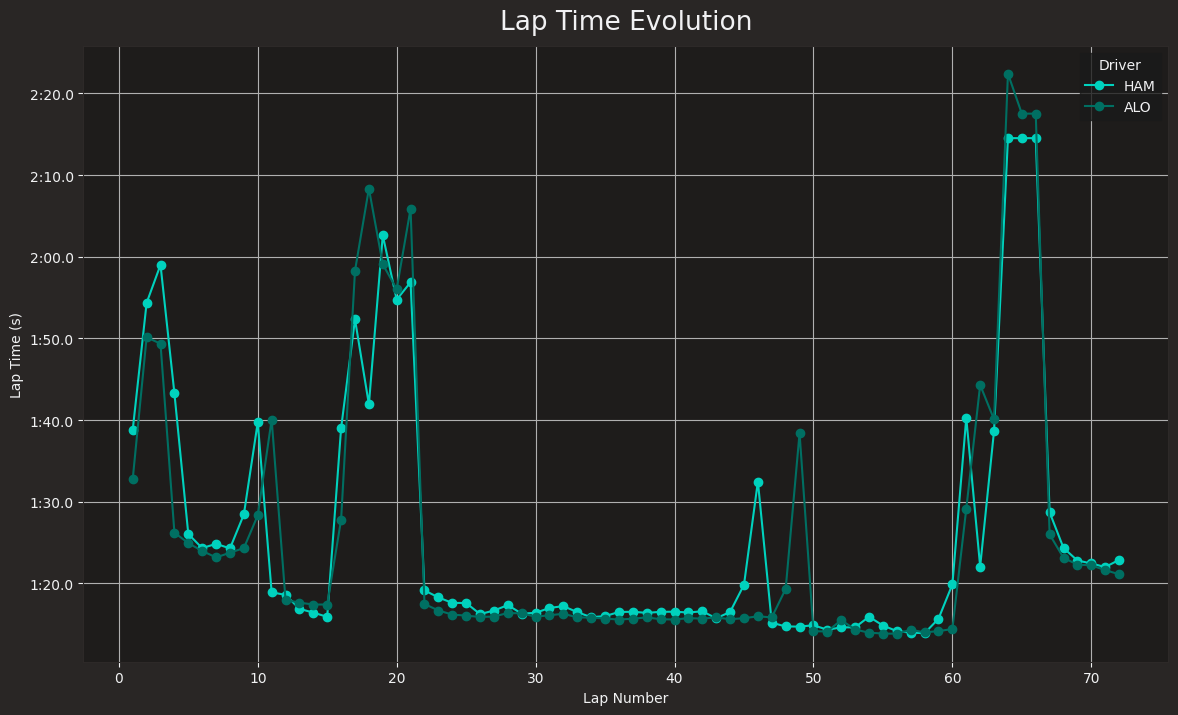

In [31]:
plt.figure(figsize=(14, 8))
for driver in drivers_to_plot:
    driver_data = merged_data[merged_data['Driver'] == driver]
    team_color = get_team_color(driver)
    plt.plot(driver_data['LapNumber'], driver_data['LapTime'], marker='o', label=driver, color=team_color)

plt.title('Lap Time Evolution')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.legend(title='Driver')
plt.grid(True)
plt.show()

In [32]:
merged_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,LapStartTime,FreshTyre,TyreLife,NumberOfPitStops,PitOutTime,PitInTime,Sector1Time(s),Sector2Time(s),Sector3Time(s),Cum.SectorTime(s),LapTime(s),LapStartTime(s),PitInTime(s),PitOutTime(s),PitStopTime(s),PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Status,Message,Category_CarEvent,Category_Drs,Category_Flag,Category_Other,Category_SafetyCar,Flag_BLACK AND WHITE,Flag_BLUE,Flag_CHEQUERED,Flag_CLEAR,Flag_DOUBLE YELLOW,Flag_GREEN,Flag_RED,Flag_YELLOW
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.676675,0.505548,1.932217,95.737,1.121812,-1.021743,0.0,0.0,0.0,0.000000,0.000000,-1.032224,-0.782261,-0.539581,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
1,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.961079,0.379537,1.956641,96.514,1.174297,-1.021743,0.0,0.0,0.0,0.436815,7.646212,-1.032004,-0.765248,-0.368175,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
2,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.675563,0.443483,1.962953,95.680,1.218362,-1.021743,0.0,0.0,0.0,0.313716,9.377063,-1.031818,-0.750964,-0.395675,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
3,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.888796,0.464548,1.987377,96.592,1.257194,-1.021743,0.0,0.0,0.0,0.391614,8.972493,-1.031655,-0.738376,-0.412762,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
4,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.823186,0.568366,2.158068,97.254,1.341808,-1.021743,0.0,0.0,0.0,0.492235,8.806602,-1.031300,-0.710949,-0.263249,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,0 days 03:25:10.720000,-1.0,0.250000,1.5,0,0,0.617459,0.452887,0.750274,83.883,0.492152,1.880784,0.0,0.0,0.0,0.428315,0.672027,1.081052,1.606763,-0.646109,False,True,False,False,False,-0.764706,0.818182,0.714286,1.0,-0.984848,-0.333333,-0.285714,TRACK CLEAR,CHEQUERED FLAG,False,False,True,False,False,False,False,True,False,False,False,False,False
1339,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 0

#### LAP TIME PLOTTING BETWEEN DRIVERS USING PLOTLY

In [33]:
def format_yaxis_labels(value):
    minutes = int(value // 60)
    seconds = int(value % 60)
    milliseconds = int((value % 1) * 1000)
    return f'{minutes}:{seconds:02}.{milliseconds:03}'

plot_data_list = []
for driver in drivers_to_plot:
    driver_data = merged_data[merged_data['Driver'] == driver].copy()
    driver_data['LapTime_sec'] = driver_data['LapTime'].dt.total_seconds()
    driver_data['TeamColor'] = get_team_color(driver)
    driver_data['Minutes'] = driver_data['LapTime_sec'] // 60
    driver_data['Seconds'] = driver_data['LapTime_sec'] % 60
    driver_data['Milliseconds'] = (driver_data['LapTime_sec'] % 1) * 1000
    plot_data_list.append(driver_data)

plot_data = pd.concat(plot_data_list, ignore_index=True)

max_lap_time_sec = plot_data['LapTime_sec'].max()
y_tick_values = list(range(0, int(max_lap_time_sec) + 10, 10))

fig = px.line(
    plot_data,
    x='LapNumber',
    y='LapTime_sec',
    color='Driver',
    hover_data={
        'LapTime_sec': False,  
        'LapNumber': True,
        'TeamColor': False,
        'Driver': True,
        'Minutes': True,
        'Seconds': True,
        'Milliseconds': True
    },
    title='Lap Time Evolution',
    labels={
        'LapNumber': 'Lap Number',
        'LapTime_sec': 'Lap Time'
    },
    markers=True,
    color_discrete_map={driver: get_team_color(driver) for driver in drivers_to_plot}
)

fig.update_traces(
    hovertemplate='<b>Driver</b>: %{customdata[1]}<br>' +
                  '<b>Lap Number</b>: %{x}<br>' +
                  '<b>Lap Time</b>: %{customdata[2]}:%{customdata[3]:02.0f}.%{customdata[4]:03.0f}<extra></extra>'
)

fig.update_yaxes(
    tickvals=y_tick_values,
    ticktext=[format_yaxis_labels(val) for val in y_tick_values],
    title='Lap Time (min:sec.msec)'
)
fig.show()

In [34]:
merged_data

,Time,Driver,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,IsAccurate,Position,LapStartTime,FreshTyre,TyreLife,NumberOfPitStops,PitOutTime,PitInTime,Sector1Time(s),Sector2Time(s),Sector3Time(s),Cum.SectorTime(s),LapTime(s),LapStartTime(s),PitInTime(s),PitOutTime(s),PitStopTime(s),PrevLapTime(s),LapΔ(s),CumLapTime(s),GapToLeader,Interval,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Status,Message,Category_CarEvent,Category_Drs,Category_Flag,Category_Other,Category_SafetyCar,Flag_BLACK AND WHITE,Flag_BLUE,Flag_CHEQUERED,Flag_CLEAR,Flag_DOUBLE YELLOW,Flag_GREEN,Flag_RED,Flag_YELLOW
0,0 days 01:03:36.820000,VER,1,1.0,0 days 00:01:31.585000,0 days 00:00:36.330000,0 days 00:00:28.929000,0 days 00:00:30.478000,False,1.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.676675,0.505548,1.932217,95.737,1.121812,-1.021743,0.0,0.0,0.0,0.000000,0.000000,-1.032224,-0.782261,-0.539581,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
1,0 days 01:03:37.462000,NOR,4,1.0,0 days 00:01:32.227000,0 days 00:00:37.353000,0 days 00:00:28.594000,0 days 00:00:30.567000,False,2.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.961079,0.379537,1.956641,96.514,1.174297,-1.021743,0.0,0.0,0.0,0.436815,7.646212,-1.032004,-0.765248,-0.368175,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
2,0 days 01:03:38.001000,ALO,14,1.0,0 days 00:01:32.766000,0 days 00:00:36.326000,0 days 00:00:28.764000,0 days 00:00:30.590000,False,3.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.675563,0.443483,1.962953,95.680,1.218362,-1.021743,0.0,0.0,0.0,0.313716,9.377063,-1.031818,-0.750964,-0.395675,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
3,0 days 01:03:38.476000,RUS,63,1.0,0 days 00:01:33.241000,0 days 00:00:37.093000,0 days 00:00:28.820000,0 days 00:00:30.679000,False,4.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.888796,0.464548,1.987377,96.592,1.257194,-1.021743,0.0,0.0,0.0,0.391614,8.972493,-1.031655,-0.738376,-0.412762,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
4,0 days 01:03:39.511000,ALB,23,1.0,0 days 00:01:34.276000,0 days 00:00:36.857000,0 days 00:00:29.096000,0 days 00:00:31.301000,False,5.0,0 days 01:02:04.960000,0.0,-0.833333,0.0,0,0,2.823186,0.568366,2.158068,97.254,1.341808,-1.021743,0.0,0.0,0.0,0.492235,8.806602,-1.031300,-0.710949,-0.263249,False,False,False,True,False,0.235294,-0.090909,0.000000,1.0,0.454545,-0.533333,-1.714286,TRACK CLEAR,LOW GRIP CONDITIONS,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0 days 03:26:34.603000,TSU,22,72.0,0 days 00:01:23.883000,0 days 00:00:28.923000,0 days 00:00:28.789000,0 days 00:00:26.171000,True,13.0,0 days 03:25:10.720000,-1.0,0.250000,1.5,0,0,0.617459,0.452887,0.750274,83.883,0.492152,1.880784,0.0,0.0,0.0,0.428315,0.672027,1.081052,1.606763,-0.646109,False,True,False,False,False,-0.764706,0.818182,0.714286,1.0,-0.984848,-0.333333,-0.285714,TRACK CLEAR,CHEQUERED FLAG,False,False,True,False,False,False,False,True,False,False,False,False,False
1339,0 days 03:26:35.827000,LAW,40,72.0,0 days 00:01:23.592000,0 days 00:00:28.792000,0 days 0

In [35]:
merged_data.to_csv('modeldata_normalized.csv', index=False)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

data = pd.read_csv('modeldata_normalized.csv')
X = data[['Driver', 'LapNumber', 'AirTemp', 'TrackTemp', 'Humidity', 'Pressure', 'WindSpeed', 'WindDirection']]  # Example features
y = data['LapTime(s)'] 

X = pd.get_dummies(X, columns=['Driver'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [40]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

In [41]:
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.25055408326262274
Root Mean Squared Error: 0.48510098126694984


#### SAMPLE INPUT

In [49]:
from sklearn.preprocessing import StandardScaler
input_data = pd.DataFrame({
    'Driver': ['VER'],  # Driver code, e.g., 'VER' for Verstappen
    'LapNumber': [10],  # Lap number
    'AirTemp': [22.0],  # Air temperature in Celsius
    'TrackTemp': [30.0],  # Track temperature in Celsius
    'Humidity': [60],  # Humidity in percentage
    'Pressure': [1010],  # Pressure in hPa
    'WindSpeed': [3.0],  # Wind speed in m/s
    'WindDirection': [180]  # Wind direction in degrees
})